# Signal Selection with multivariate classification
The file *signal.txt* and *background.txt* each contain 10K values of seven features used to characterise signal and background for a particle decaying into three other particles: P --> P1 P2 P3. The signal is real particle decays and the background is random combinations of particles which do not represent anything physical.

---
We load the libraries and the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# load the data
signal = pd.read_csv("data/signal.txt", sep=" ")
background = pd.read_csv("data/background.txt", sep=" ")

Next we prepare the data for machine learning by labelling them and explore the data afterward.

In [4]:
 # set the column names
features = ["PT1", "PT2", "P1", "P2", "TotalPT", "VertexChisq", "Isolation"]
signal.columns = features
background.columns = features
# create the ML frame
signal["label"] = 1.0
background["label"] = 0.0
ML_frame = pd.concat([signal, background])

We make a histogram for each feature, overlaying the signal and background on the same plot to explore the features

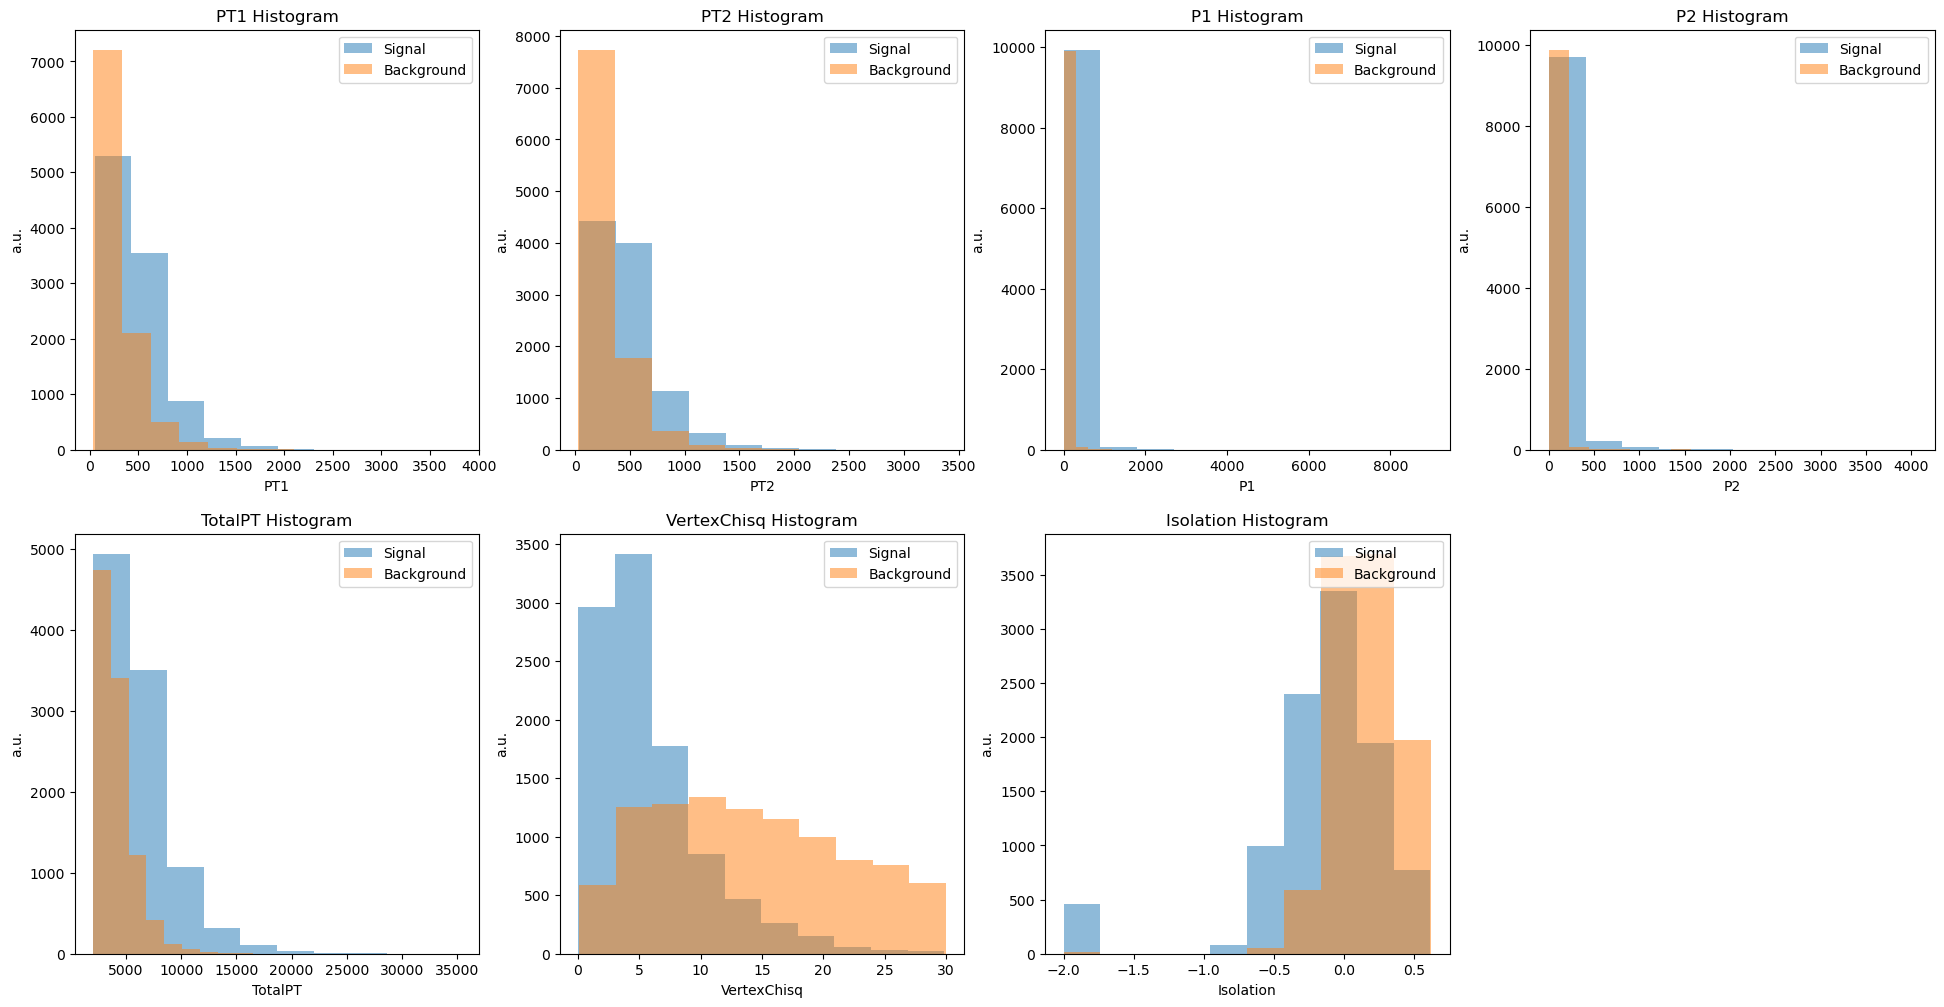

In [21]:
fig, ax = plt.subplots(2, 4, figsize = (24, 12))
ax = np.ravel(ax)
ax[-1].axis("off") # remove the last axis

for i, feature in enumerate(features):
    ax[i].hist(signal[feature], alpha=.5, label="Signal")
    ax[i].hist(background[feature], alpha=.5, label="Background")
    ax[i].set_ylabel("a.u.")
    ax[i].set_xlabel(feature)
    ax[i].set_title(f"{feature} Histogram")
    ax[i].legend(loc="upper right")

Next, we calculate the Fisher score for each feature and use it to rank the importance of the features.

In [23]:
def fisher_score(frame, feature:str):
    """
    computes fisher score of given feature for given frame
    :param frame: pandas df, columns label separates categories
    :param feature: feature of df to calculate fisher score upon
    :return: fisher score of feature
    """
    # categories = pd.unique(ML_frame["label"])
    # c = len(categories)
    mu_k = frame.groupby("label").mean()[feature]
    n_k = frame.groupby("label").count()[feature]
    mu = frame[feature].mean()
    std = frame[feature].std()

    return (n_k * (mu_k - mu)**2).sum() / std ** 2

# calculate with dict comprehension
fisher_scores = {feat: fisher_score(frame=ML_frame, feature=feat) for feat in features}
pd.DataFrame({"attribute": list(fisher_scores.keys()),
              "fisher_score":list(fisher_scores.values())}).sort_values(by = ["fisher_score"],
                                                                        ascending = False)

,attribute,fisher_score
5,VertexChisq,5932.051392
4,TotalPT,2942.592717
6,Isolation,2709.000174
0,PT1,2503.712171
1,PT2,2485.746584
3,P2,886.999383
2,P1,826.042923


## Rectangular Selection

Next, we select the three highest features and optimise rectangular selection to maximise the metric
$$accuracy = \frac{TP + TN}{TP + FP + FN + TN}$$
We will use the `scipy.optimze.minimize` functions to maximize, thus we need to change the sign of the metric function output.
The metric is described with this function:

In [33]:
def optimize_rectangular_selection(cut):
    """
    built to plug in scipy.optimize.minimze, optimizing accuracy measures from confusion matrix
    :param cut: selection cut
    :return: accuracy rectangular selections calculated from confusion matrix
    """

    global signal, background, best_features

    signal_cut = np.logical_and(signal[best_features[0]] > cut[0],
                                  signal[best_features[1]] > cut[1],
                                  signal[best_features[2]] > cut[2])

    background_cut = np.logical_and(background[best_features[0]] > cut[0],
                                  background[best_features[1]] > cut[1],
                                  background[best_features[2]] > cut[2])

    signal_efficiency = len(signal[signal_cut]) / len(signal)
    background_efficiency = len(background[background_cut]) / len(background)

    TP = len(signal) * signal_efficiency
    FP = len(signal) * (1 - signal_efficiency)
    TN = len(background) * (1 - background_efficiency)
    FN = len(background) * background_efficiency

    return -1 * ((TP + TN) / (TP + FP + TN + FN)) # return - result to use minimize function

We select the best features by slicing:

In [34]:
best_features = np.array(sorted(fisher_scores.items(), key=lambda item: item[1])[-3:])[:, 0]
best_features

array(['Isolation', 'TotalPT', 'VertexChisq'], dtype='<U32')

Our tactic is now to think qualitatively and think of some initial guesses for the optimization that cover the all parts of the data set:

In [35]:
# minimize with scipy
logical_bounds = list(zip(tuple(signal[best_features].min()), tuple(signal[best_features].max())))
init_guess_mean = list(signal[best_features].mean())  # unused
init_guess_1stq = list(signal[best_features].quantile(q=1/4))
init_guess_3rdq = list(signal[best_features].quantile(q=3/4))

init_guess_names = ["0", "1stQ", "mean", "3rdQ"]

Next, we find optimization methods that fit our boundary condition after defining the function for rectangular selection implementing the metric.

In [36]:
opt_methods = ["Nelder-Mead", "Powell", "TNC", "SLSQP"]  # only methods than can handle bounds

# dictionary of trying methods and inital guesses

tune_optimzation = {method: {guess_name: minimize(fun=optimize_rectangular_selection,
                                                  x0=init_guess_3rdq,
                                                  method=method,
                                                  bounds=logical_bounds) for guess_name, guess in
                             zip(init_guess_names, [[0, 0, 0],
                                                    init_guess_1stq,
                                                    init_guess_mean,
                                                    init_guess_3rdq])} for method in opt_methods}



In [41]:
# evaluate the dictionary
optimal_configuration = {"acc": [0],
                         "method": [None],
                         "guess_name": [None]}  # make it a list


for key_outer in opt_methods:
    for key_inner in init_guess_names:
        opt_x = - tune_optimzation[key_outer][key_inner].fun  # function value of optimized results
        if opt_x >= optimal_configuration["acc"][-1]:
            optimal_configuration["acc"].append(opt_x)
            optimal_configuration["method"].append(key_outer)
            optimal_configuration["guess_name"].append(key_inner)

opt_config_df = pd.DataFrame(optimal_configuration)
opt_config_df = opt_config_df[opt_config_df["acc"] == opt_config_df["acc"].max()]

print(f"Using scipy.optimize.minimze with the methods {opt_methods} and initial guess types {init_guess_names} "
      f"leaves us with the conclusion that the Powell algorithm converges succesful and maximizes the metric, but \n"
      f"doesn't depend on the initial guess as visualized in the optimized results table:\n")
print(opt_config_df)
print(f"\nThus the resulting accuracy from the rectanglular selection is {opt_config_df.iloc[0,0].round(3)}.")

Using scipy.optimize.minimze with the methods ['Nelder-Mead', 'Powell', 'TNC', 'SLSQP'] and initial guess types ['0', '1stQ', 'mean', '3rdQ'] leaves us with the conclusion that the Powell algorithm converges succesful and maximizes the metric, but 
doesn't depend on the initial guess as visualized in the optimized results table:

        acc  method guess_name
5  0.662666  Powell          0
6  0.662666  Powell       1stQ
7  0.662666  Powell       mean
8  0.662666  Powell       3rdQ

Thus the resulting accuracy from the rectanglular selection is 0.663.


## BDT classifier
Now we include the full set of seven features and recalculate the obtained accuracy using the BDT. How does the accuracy improve?

We first implement the core function defining our BDT classifier:

In [43]:
def BDT_classifier(X:np.ndarray, y:np.ndarray):
    """
    Splits data in test and training set, trains model and uses prediction accuracy of test set
    to eventually measure of accuracy of bdt classifier
    :param X: features of ML-model
    :param y: prediction-goal of ML-model
    :return: accuracy score of trained bdt model
    """
    X_train,X_test, y_train,y_test = train_test_split(X, y,
                                                      test_size=0.3, random_state=420)



    # make a BDT
    dt = DecisionTreeClassifier(max_depth=2,
                                min_samples_leaf=int(0.01*len(X)))
    bdt = AdaBoostClassifier(dt,
                             algorithm='SAMME',
                             n_estimators=50,
                             learning_rate=0.1)

    # optimise the parameters of the weights using the training sample
    bdt.fit(X_train, y_train)
    y_predicted = bdt.predict(X_test)
    score_BDT = (y_test == y_predicted).sum() / len(y_test)
    # print(y_test)
    # print(y_predicted)

    return score_BDT

Finally, we plug in our features and the label and make use of our function to decide whether the less 4 important features make a difference or whether it is enough to only train the classifier with the best 4 features.

In [46]:
best_X = np.asarray(ML_frame[best_features])
y = np.asarray(ML_frame["label"])

print(f"Accuracy of fit with best features: {BDT_classifier(X=best_X, y=y)}"
      f"\nThe optimization via BDT leads to a higher accuracy, implying that the BDT is better suited to \n "
      f"seperate the signal from the background noise.\n")

# e)
all_X = np.asarray(ML_frame[features])
print(f"Accuracy of fit with all features: {BDT_classifier(X=all_X, y=y)}"
      f"\nThe accuracy does improves for around 8%, which means that the 4 features with lower fisher scores, do \n"
      f"explain differences between signal and background data that should not be neglected.")

Accuracy of fit with best features: 0.8193333333333334
The optimization via BDT leads to a higher accuracy, implying that the BDT is better suited to 
 seperate the signal from the background noise.

Accuracy of fit with all features: 0.8965
The accuracy does improves for around 8%, which means that the 4 features with lower fisher scores, do 
explain differences between signal and background data that should not be neglected.
